## News classification using Bert

Import important libraries 

In [1]:
# Important libraries
import pandas as pd
import numpy as np
import re # to use regular expression pattern 
import datetime as dt  # to parse to datetime
import string
from scipy import stats

#text processing and visualization
import nltk 
from nltk.tokenize import word_tokenize, regexp_tokenize, TweetTokenizer
from collections import Counter, defaultdict
from nltk.corpus import stopwords          # to access stop words 
from nltk.stem import WordNetLemmatizer, PorterStemmer   # for lemmatization or steming

from gensim.corpora.dictionary import Dictionary   # to map token , id and create corpus
from sklearn.manifold import TSNE
#from wordcloud import WordCloud,STOPWORDS # to visualize frequeent words 
from gensim.models import  Word2Vec  #  word embeding 
from gensim.models.phrases import Phraser, Phrases # to use for bigram modeling,
from gensim.models.word2vec import LineSentence
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.tfidfmodel import TfidfModel # tfidf using gensim

#for preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # to make word vectors 
from sklearn.model_selection import train_test_split  

# For modeling and evaluation 
from sklearn.naive_bayes import MultinomialNB  # for Naive Baye's  classification
from sklearn.linear_model import LogisticRegression
from sklearn import metrics # to evaluate model performance

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import pandas as pd

## Read the data

In [3]:
true= pd.read_csv("drive/My Drive/NLP_files/True.csv", parse_dates=["date"])     # the true news data
fake= pd.read_csv("drive/My Drive/NLP_files/Fake.csv")     # the fake news data

In [4]:
true.head(3) # the first few rows of real dataframe

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31


In [ ]:
true.shape

(21417, 4)

### 1.1) Add labels(fake/true) to the  dataframs

In [5]:
# create a new column called is_fake and label as 0 for true news 
true["label"]="true"
# create a new column called is_fake and label as 1 for fake news 
fake["label"]= "fake"

In [6]:
# parse the date column into datetime. 
#Since it has two datetime format, we need two formats to parse.  
def parsing_datetime(string):
    for f in ("%B %d, %Y", '%d-%b-%y', "%b %d, %Y"): # format  19-Feb-18
        try:
            return dt.datetime.strptime(string, f)
        except ValueError:
            pass
        
# parse the date column of fake dataframe into datetime
fake.date= fake.date.apply(lambda x: parsing_datetime(x))

In [7]:
fake.head(3)

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,fake


### 1.2) Merge the real and fake dataframe

In [8]:
# Merge the fake and read dataframe
news= pd.concat([true,fake], axis=0, ignore_index=True)#.reset_index() # reset index to have unique index

### 2) Data Cleaning and Preprocessing 
Remove html tags, url links, special characters, punctuations , emoji and stopwords. Lets keep the punctuation to use bert.


In [9]:
#patterns= [emoji, url, html]
def remove_pattern(text, patterns):
    """The function remove_pattern returns the new string with a set of patterns removed.
       Parameters:
       ------------
       data: the text from which the pattern will be removed
       patterns: is the set of patterns(iterable) we are intereted to remove from the text
       """
           
    for pattern in patterns:
        new= re.sub(pattern, "", text)
        text= new 
    return new

In [10]:
# patterns to be extracted and to be removed from the data 
emoji = "[\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\u2600-\u26FF\u2700-\u27BF\U000024C2-\U0001F251]+"

url= re.compile("https?://\S+|www\.\S+")                     # pattern for url
html= r'<.*?>'                                               # pattern for html tag
num_with_text= r"\S*\d+\S*"                                  # pattern for digit 
#punctuation= r"[#@&%$~=\.;:\?,(){}\"\“\”\‘\'\*!\+`^<>\[\]\-]+"      #pattern for punctuations and special characters   
apostroph=r"\’s?"
# collect the patterns 
patterns=[emoji, url, html, num_with_text, apostroph] # punctuation removed

### 2.1) Clean merged data
At this statage of data cleaning ,the emoji, url links, html tag, digits and special characters are removed.

In [11]:
# Clean the title of merged data using regular expression patterns
news_clean_title = news.title.apply(remove_pattern, patterns= patterns)
news_clean_text= news.text.apply(remove_pattern, patterns= patterns)

In [ ]:
news_clean_title.head()

0    As U.S. budget fight looms, Republicans flip t...
1    U.S. military to accept transgender recruits o...
2    Senior U.S. Republican senator: 'Let Mr. Muell...
3    FBI Russia probe helped by Australian diplomat...
4    Trump wants Postal Service to charge 'much mor...
Name: title, dtype: object

## Calssifiation using BERT: Using Transformers module from 

Reference: https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

In [12]:
!pip install -qq transformers

     |████████████████████████████████| 778kB 3.5MB/s 
     |████████████████████████████████| 890kB 13.3MB/s 
     |████████████████████████████████| 3.0MB 20.4MB/s 
     |████████████████████████████████| 1.1MB 23.1MB/s 


In [13]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
device

device(type='cuda', index=0)

### Data Preprocessing

Add special tokens to separate sentences and do classification
, Pass sequences of constant lengt(introduce padding), 
Create array of 0s (pad token) and 1s (real token) called attention mask

In [16]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [17]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)

In [18]:
sample_txt="hello world. this is me. today is thursday."

In [19]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
  truncation=True # to truncate excess tokens to meet the maximum length
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [20]:
encoding["input_ids"]

tensor([[ 101, 7592, 2088, 1012, 2023, 2003, 2033, 1012, 2651, 2003, 9432, 1012,
          102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [21]:
encoding["attention_mask"]# shows 1 for real token and 0 for pad tokens 

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
#token_leng=[]
#for title in news_clean_title:
#  tokens=tokenizer.encode(title, max_length=512)
#  token_leng.append(len(tokens))

Text(0, 0.5, 'Frequency')

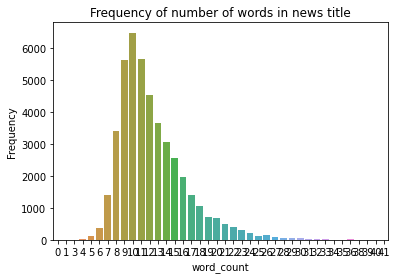

In [22]:
sns.countplot(news_clean_title.apply(lambda x: len(x.split())))
plt.title("Frequency of number of words in news title")
plt.xlabel("word_count")
plt.ylabel("Frequency")

In [23]:
news_clean_title.apply(lambda x: len(x.split())).argmax() # maximum number of words in a cleaned title

30652

In [27]:
m= news_clean_title.iloc[30652]


In [25]:
Max_LEN= 128 # though max number of tokens are 41 

In [30]:
class NewsDataset(Dataset):
  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.text)
  def __getitem__(self, item):
    row = str(self.text[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      row,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      truncation=True, # to truncate excess tokens to meet the maximum length
      return_tensors='pt',
    )
    return {
      'row_text': row,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

### Split the data into training validating and test data

In [31]:
news["cleaned_title"]= news_clean_title
news["cleaned_text"]= news_clean_text
dicmap= {"true": 0, "fake": 1} # lable true news as 0 and fake news as 1
news["is_fake"]= news.label.apply(lambda x: dicmap[x]) 

In [32]:
news.head(2)

,title,text,subject,date,label,cleaned_title,cleaned_text,is_fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,true,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,true,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,0


In [34]:
# copy the news to data_brt. the data to besplited into training, validating and test set
data_brt= news[["cleaned_title","cleaned_text","is_fake"]] 

In [35]:
data_brt.head(2)

,cleaned_title,cleaned_text,is_fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,0


In [36]:
#train_data, validate_data, test_data (80%, 10%, 10% respectively)
train_data, validate_data, test_data= np.split(data_brt.sample(frac=1, random_state=42), [ int(.8*len(news)), int(.9*len(news))])

In [37]:
train_data.shape, validate_data.shape, test_data.shape

((35918, 3), (4490, 3), (4490, 3))

### Data loader
This works only for the tittle of the news . For the text of the news, use similar approach.

In [38]:
# cleate dataloader for news title
def create_data_loader(data, tokenizer, max_len, batch_size):
    ds = NewsDataset(
    text=data.cleaned_title.to_numpy(),
    targets=data.is_fake.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
    )
    return DataLoader( ds,batch_size=batch_size, num_workers=4)

BATCH_SIZE = 16
train_data_loader = create_data_loader(train_data, tokenizer, Max_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(validate_data, tokenizer, Max_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_data, tokenizer, Max_LEN, BATCH_SIZE)

In [39]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['row_text', 'input_ids', 'attention_mask', 'targets'])

In [43]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])


### Classification using BERT

In [44]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [45]:
# for the sample data
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [46]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [47]:
pooled_output.shape

torch.Size([1, 768])

In [48]:
class NewsClassifier(nn.Module):
  def __init__(self, n_classes):
    super(NewsClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [49]:
#create classifier instance and move it to the GPU
model = NewsClassifier(2) # we have two classes, fake and real
model = model.to(device)

In [50]:
# move training data to GPU
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 128])
torch.Size([16, 128])


In [51]:
nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5273, 0.4727],
        [0.4295, 0.5705],
        [0.5113, 0.4887],
        [0.5898, 0.4102],
        [0.4873, 0.5127],
        [0.6279, 0.3721],
        [0.6020, 0.3980],
        [0.5361, 0.4639],
        [0.5141, 0.4859],
        [0.4637, 0.5363],
        [0.3687, 0.6313],
        [0.5214, 0.4786],
        [0.5148, 0.4852],
        [0.5882, 0.4118],
        [0.5026, 0.4974],
        [0.3977, 0.6023]], device='cuda:0', grad_fn=<SoftmaxBackward>)

Recommendations for fine-tuning:

Batch size: 16, 32
Learning rate (Adam): 5e-5, 3e-5, 2e-5
Number of epochs: 2, 3, 4

In [52]:
#Training 
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
  )
loss_fn = nn.CrossEntropyLoss().to(device)

In [54]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [55]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [58]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train_data)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(validate_data)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.08806357242139189 accuracy 0.9736343894426194
Val   loss 0.07789061358980495 accuracy 0.978173719376392

Epoch 2/10
----------
Train loss 0.02498175636839271 accuracy 0.9938470961634835
Val   loss 0.10653501629579318 accuracy 0.9815144766146994

Epoch 3/10
----------
Train loss 0.010627569522967154 accuracy 0.9978005456873991
Val   loss 0.09437755113647985 accuracy 0.9855233853006682

Epoch 4/10
----------
Train loss 0.006801564279401783 accuracy 0.9986914638899717
Val   loss 0.09854249891410384 accuracy 0.9855233853006682

Epoch 5/10
----------
Train loss 0.004570542943245625 accuracy 0.9992761289604098
Val   loss 0.15891547046662208 accuracy 0.9826280623608018

Epoch 6/10
----------
Train loss 0.0036582352108556642 accuracy 0.9992761289604098
Val   loss 0.11999008320031099 accuracy 0.9846325167037863

Epoch 7/10
----------
Train loss 0.0010591361563094734 accuracy 0.9998329528370177
Val   loss 0.1379146193169078 accuracy 0.9855233853006682

Epoch 8/

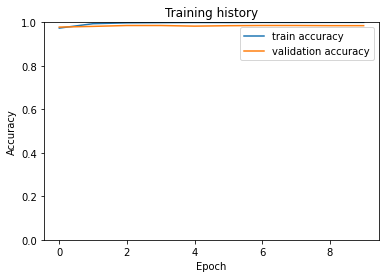

In [59]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [62]:
# model = NewsClassifier(2) # len(class_names)
#model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

<All keys matched successfully>

### Validate with test data 

In [60]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test_data)
)
test_acc.item()

0.9897550111358575

In [64]:
def get_predictions(model, data_loader):
  model = model.eval()
  news_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["row_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      news_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return news_texts, predictions, prediction_probs, real_values

In [65]:
y_news_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [69]:
print(classification_report(y_test, y_pred, target_names=["true","fake"]))

              precision    recall  f1-score   support

        true       0.98      0.99      0.99      2141
        fake       0.99      0.98      0.99      2349

    accuracy                           0.99      4490
   macro avg       0.99      0.99      0.99      4490
weighted avg       0.99      0.99      0.99      4490



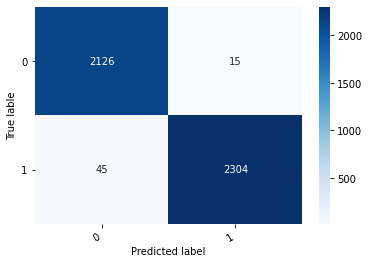

In [70]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True lable')
  plt.xlabel('Predicted label');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=[0,1], columns=[0,1]) # [0,1] is class name
show_confusion_matrix(df_cm)

In [76]:
y_news_texts[1]

'China says U.S. should respect concerns on Taiwan'

In [80]:
y_test[1]

tensor(0)

In [83]:
idx = 2
class_names= ["true","fake"]
news_text_ttl = y_news_texts[idx]
true_label = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})
print("\n".join(wrap(news_text_ttl)))
print()
print(f'True prediction: {class_names[true_label]}')

HOW  ILLEGAL KIDS Have Been Able To Avoid Deportation

True prediction: fake


In [84]:
y_pred[2] #prediction

tensor(1)

### Predicting on raw text( may use snopes data here)

In [86]:
snopes_data= ["Is This James Earl Jones Dressed as Darth Vader", 
"David Rockefeller's Sixth Heart Transplant Successful at Age 99", 
"Did Bloomington Police Discover Over 200 Penises During Raid at a Mortician's Home?", 
"Is the Trump Administration Price Gouging Puerto Rico Evacuees and Seizing Passports?",
"2017 Tainted Halloween Candy Reports 11/5/2014", 
"Did President Trump Say Pedophiles Will Get the Death Penalty?", 
"Michelle Obama Never Placed Her Hand Over Her Heart During the National Anthem?",
"Katy Perry Reveals Penchant for Cannibalism?" ,
"Is a Virginia Church Ripping Out an 'Offensive' George Washington Plaque?", 
"Were Scientists Caught Tampering with Raw Data to Exaggerate Sea Level Rise?",
"Did Trump Retweet a Cartoon of a Train Hitting a CNN Reporter?",
"Did Pipe-Bombing Suspect Cesar Sayoc Attend Donald Trump Rallies?",
"Did President Trump’s Grandfather Beg the Government of Bavaria Not to Deport Him?",
"Did Gun Violence Kill More People in U.S. in 9 Weeks than U.S. Combatants Died on D-Day?",
 "Did the Florida Shooter’s Instagram Profile Picture Feature a ‘MAGA’ Hat?",
"Wisconsin Department of Natural Resources Removes References to ‘Climate’ from Web Site",
 "Hillary Clinton Referenced RFK Assassination as Reason to Continue 2008 Campaign",
  "Did Richard Nixon Write a Letter Predicting Donald Trump’s Success in Politics?", 
"Did a Twitter User Jeopardize Her NASA Internship by Insulting a Member of the National Space Council?",
"Did WaPo Headline Call IS Leader al-Baghdadi an ‘Austere Religious Scholar’?"]  

label_actual = ["fake", "fake","fake","fake","fake","mixed", "fake","fake","mostly_false","fake","true",
               "true", "true","true","true","true","true","true","true","true"] # rated by Snopes
label_adjusted = ["fake", "fake","fake","fake","fake","fake", "fake","fake","fake","fake","true","true",
                  "true","true","true","true","true","true","true","true"]  # adjusted to fake or true

In [93]:
snopes_pred=[]
for ttl in snopes_data:
  encoded_review = tokenizer.encode_plus(
    ttl,
    max_length=Max_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    truncation=True,
    return_tensors='pt',
  )

  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  snopes_pred.append(class_names[prediction])
print(f'Snopes news title: {snopes_data}')
print(f'Prediction  : {snopes_pred}')

Snopes news title: ['Is This James Earl Jones Dressed as Darth Vader', "David Rockefeller's Sixth Heart Transplant Successful at Age 99", "Did Bloomington Police Discover Over 200 Penises During Raid at a Mortician's Home?", 'Is the Trump Administration Price Gouging Puerto Rico Evacuees and Seizing Passports?', '2017 Tainted Halloween Candy Reports 11/5/2014', 'Did President Trump Say Pedophiles Will Get the Death Penalty?', 'Michelle Obama Never Placed Her Hand Over Her Heart During the National Anthem?', 'Katy Perry Reveals Penchant for Cannibalism?', "Is a Virginia Church Ripping Out an 'Offensive' George Washington Plaque?", 'Were Scientists Caught Tampering with Raw Data to Exaggerate Sea Level Rise?', 'Did Trump Retweet a Cartoon of a Train Hitting a CNN Reporter?', 'Did Pipe-Bombing Suspect Cesar Sayoc Attend Donald Trump Rallies?', 'Did President Trump’s Grandfather Beg the Government of Bavaria Not to Deport Him?', 'Did Gun Violence Kill More People in U.S. in 9 Weeks than U.